In [1]:
import sqlite3
import pandas as pd
from scipy.stats import ttest_ind, levene
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Connect to the database
db_path = 'financial_data.db'
conn = sqlite3.connect(db_path)

In [2]:
# Step 2: Fetch FSLR and ENPH data
query = """
    SELECT Asset, Date, Close
    FROM solar_data
    WHERE Asset IN ('FSLR', 'ENPH')
"""
data = pd.read_sql(query, conn)

In [3]:
# Step 3: Calculate daily returns
data['Return'] = data.groupby('Asset')['Close'].pct_change()

# Separate data for FSLR and ENPH
fslr_data = data[data['Asset'] == 'FSLR']
enph_data = data[data['Asset'] == 'ENPH']

In [4]:
# Step 4: Statistical tests
# Test for average return difference
t_stat, p_value_ttest = ttest_ind(fslr_data['Return'].dropna(), enph_data['Return'].dropna())
# Test for volatility difference
vol_fslr = fslr_data['Return'].std()
vol_enph = enph_data['Return'].std()
f_stat, p_value_f_test = levene(fslr_data['Return'].dropna(), enph_data['Return'].dropna())

print(f"T-Test: t-statistic = {t_stat:.4f}, p-value = {p_value_ttest:.4f}")
print(f"F-Test for Volatility: f-statistic = {f_stat:.4f}, p-value = {p_value_f_test:.4f}")
print(f"Volatility: FSLR = {vol_fslr:.4f}, ENPH = {vol_enph:.4f}")

T-Test: t-statistic = -0.8911, p-value = 0.3729
F-Test for Volatility: f-statistic = 248.0492, p-value = 0.0000
Volatility: FSLR = 0.0304, ENPH = 0.0512



The A/B testing results are summarized below:

T-Test (Mean Returns Comparison)
t-statistic: -0.8911
p-value: 0.3729
This indicates that the mean returns of FSLR and ENPH are not significantly different at typical significance levels (e.g., 0.05). There is no strong evidence to conclude that one performs better than the other in terms of average returns.
F-Test (Volatility Comparison)
f-statistic: 248.0492
p-value: 0.0000
This result shows a significant difference in volatility between FSLR and ENPH, with ENPH exhibiting higher volatility. The p-value is effectively 0, meaning the observed difference in volatilities is unlikely due to random chance.
Volatility Statistics
FSLR Volatility: 0.0304
ENPH Volatility: 0.0512
ENPH has noticeably higher volatility, suggesting that its stock experiences larger price fluctuations compared to FSLR.

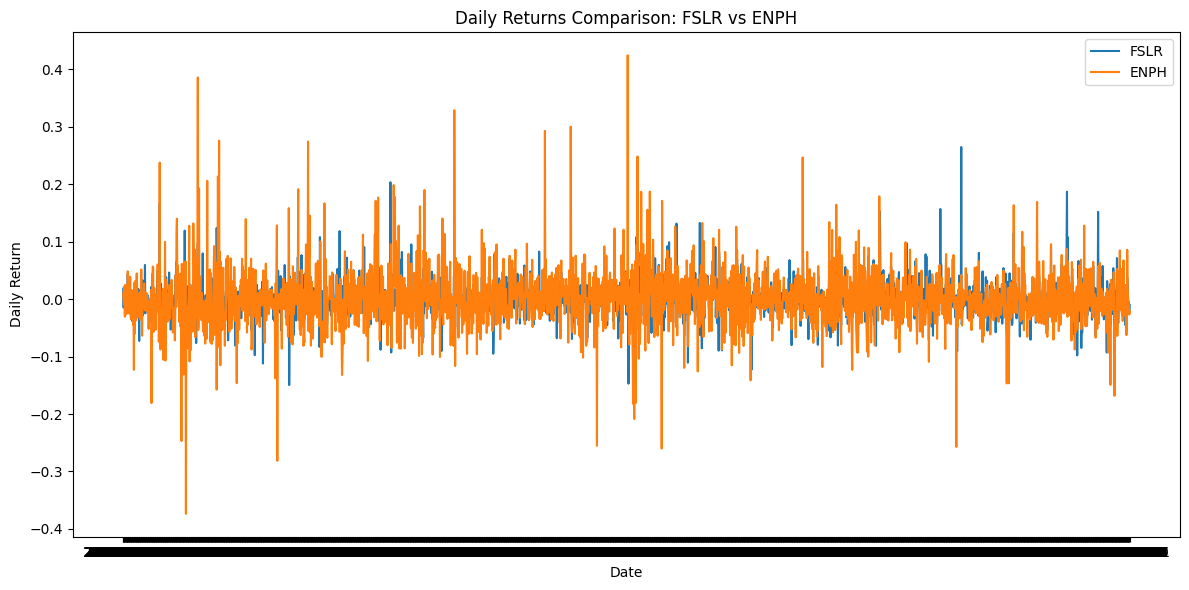

In [5]:
# Step 5: Visualization
# Returns over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=fslr_data, x='Date', y='Return', label='FSLR')
sns.lineplot(data=enph_data, x='Date', y='Return', label='ENPH')
plt.title('Daily Returns Comparison: FSLR vs ENPH')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.tight_layout()
plt.show()

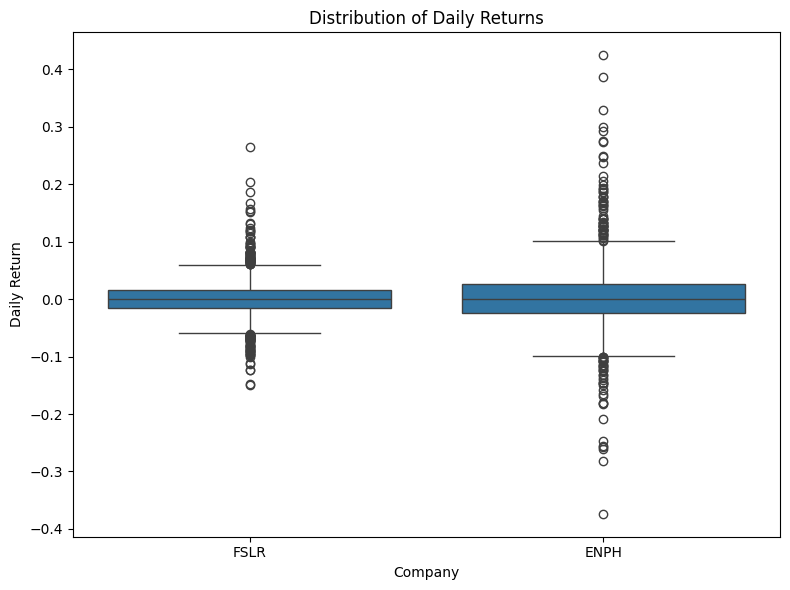

In [6]:
# Boxplots for returns
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Asset', y='Return')
plt.title('Distribution of Daily Returns')
plt.ylabel('Daily Return')
plt.xlabel('Company')
plt.tight_layout()
plt.show()

# Close the database connection
conn.close()

In [17]:
from scipy.stats import f_oneway
# Step 1: Connect to SQLite database
db_path = '/content/financial_data.db'
conn = sqlite3.connect(db_path)

In [18]:
# Step 2: Fetch commodity prices
commodity_query = """
    SELECT Date, Asset AS Commodity, Close AS Price
    FROM indicators_data
    WHERE Asset IN ('CL=F', 'NG=F', 'LIT', 'URA')
"""
commodity_data = pd.read_sql(commodity_query, conn)
commodity_data['Date'] = pd.to_datetime(commodity_data['Date'])


In [19]:
# Step 3: Fetch stock prices for FSLR and ENPH
stock_query = """
    SELECT Date, Asset AS Company, Close AS Price
    FROM solar_data
    WHERE Asset IN ('FSLR', 'ENPH')
"""
stock_data = pd.read_sql(stock_query, conn)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])


In [20]:
# Step 4: Calculate daily returns for stocks
stock_data['Return'] = stock_data.groupby('Company')['Price'].pct_change()


In [21]:
# Step 5: Merge commodity and stock data
commodity_data['Type'] = 'Commodity'
stock_data['Type'] = 'Stock'
merged_data = pd.concat([commodity_data, stock_data], axis=0, ignore_index=True)


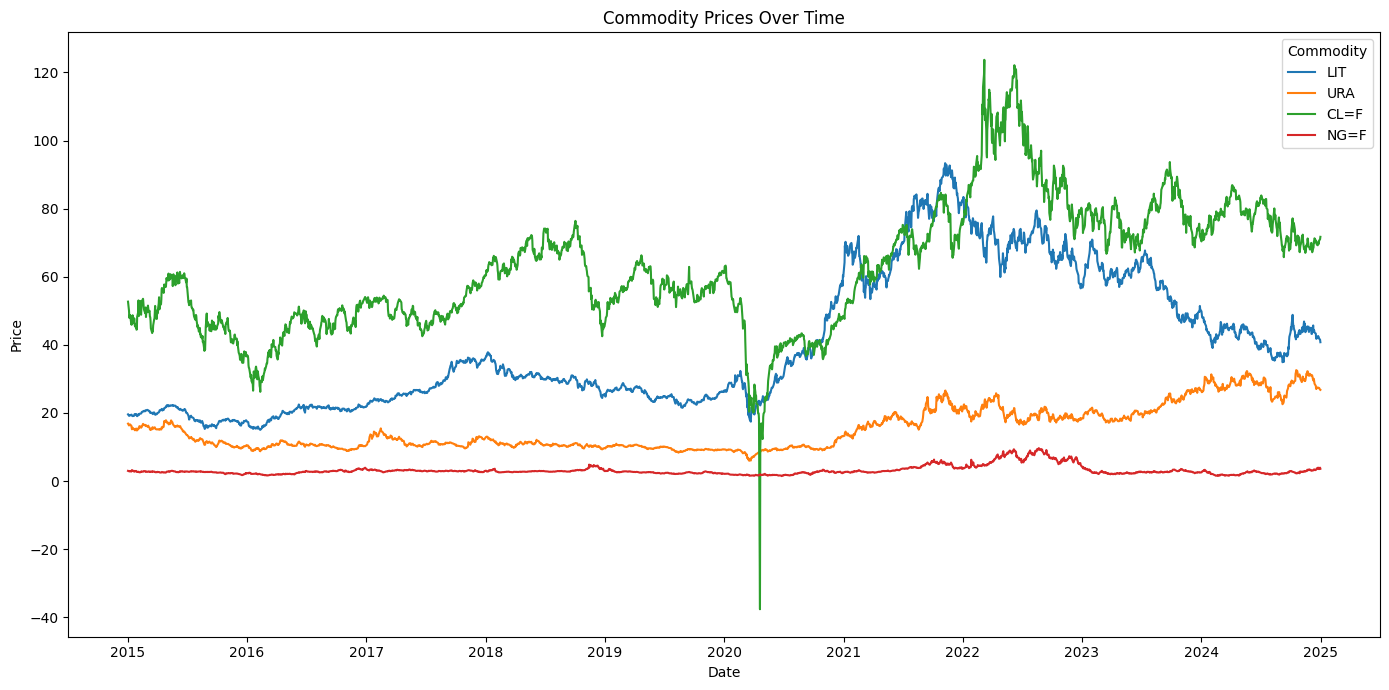

In [22]:
# Step 6: Plot commodity prices
plt.figure(figsize=(14, 7))
sns.lineplot(data=commodity_data, x='Date', y='Price', hue='Commodity', palette='tab10')
plt.title('Commodity Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(title='Commodity')
plt.tight_layout()
plt.show()

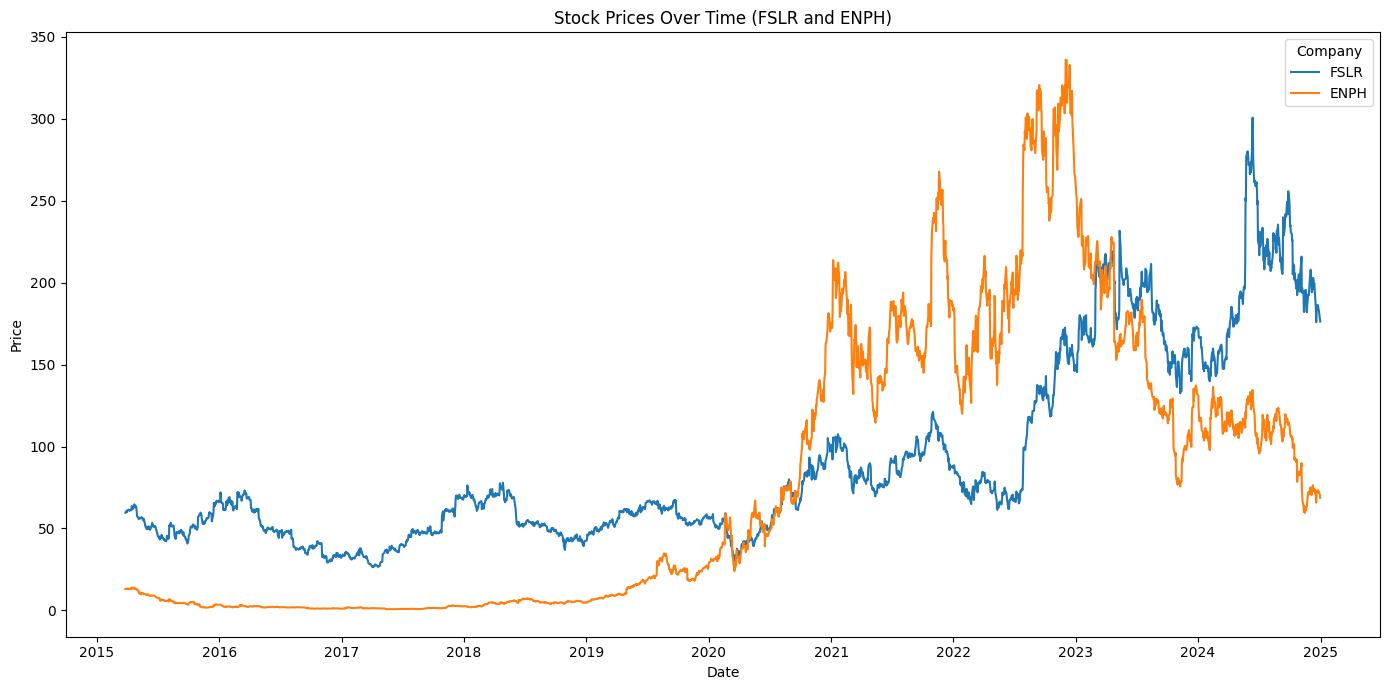

In [23]:
# Step 7: Plot stock prices
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='Date', y='Price', hue='Company', palette='tab10')
plt.title('Stock Prices Over Time (FSLR and ENPH)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(title='Company')
plt.tight_layout()
plt.show()

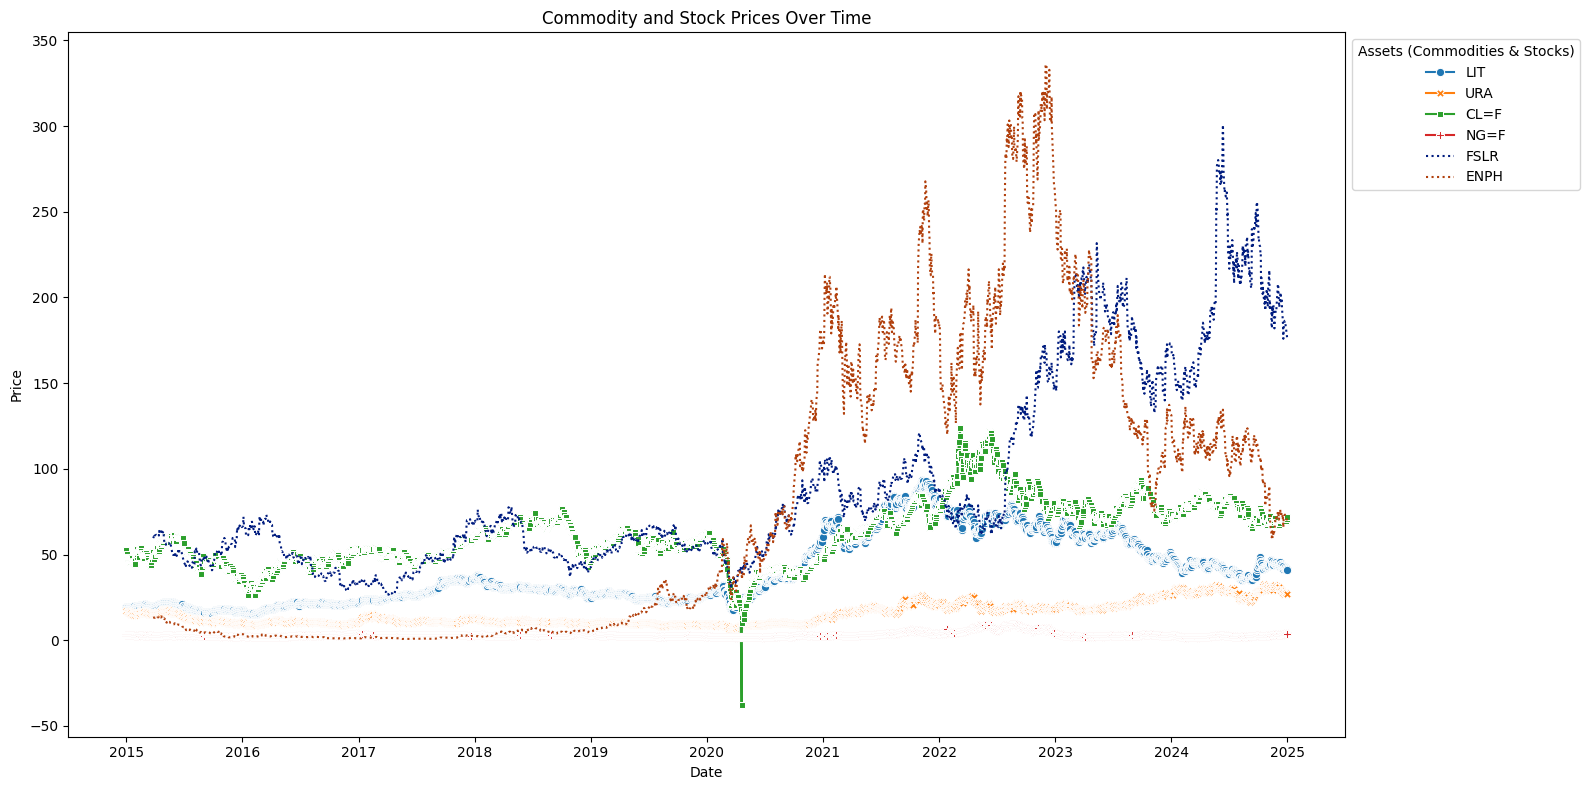

In [24]:
# Step 8: Combined plot for commodities and stocks
plt.figure(figsize=(16, 8))
sns.lineplot(data=commodity_data, x='Date', y='Price', hue='Commodity', style='Commodity', markers=True, dashes=False, legend="full")
sns.lineplot(data=stock_data, x='Date', y='Price', hue='Company', linestyle='dotted', palette='dark')
plt.title('Commodity and Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(title='Assets (Commodities & Stocks)', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [25]:
# Step 9: Correlation analysis (stock returns and prices)
correlation_data = stock_data[['Return', 'Price']].dropna()
correlation_matrix = correlation_data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
          Return     Price
Return  1.000000  0.010291
Price   0.010291  1.000000


In [26]:
# Step 10: Prepare data for ANOVA
anova_data = stock_data[['Company', 'Return']].dropna()

# Group returns for each company
fslr_returns = anova_data[anova_data['Company'] == 'FSLR']['Return']
enph_returns = anova_data[anova_data['Company'] == 'ENPH']['Return']

# Perform ANOVA for returns
anova_returns_result = f_oneway(fslr_returns, enph_returns)
print(f"ANOVA for Returns: F-statistic = {anova_returns_result.statistic:.4f}, p-value = {anova_returns_result.pvalue:.4f}")

# Perform ANOVA for each commodity price against returns
for commodity in commodity_data['Commodity'].unique():
    commodity_prices = commodity_data[commodity_data['Commodity'] == commodity]['Price'].dropna()
    anova_price_result = f_oneway(fslr_returns, commodity_prices)
    print(f"ANOVA for {commodity}: F-statistic = {anova_price_result.statistic:.4f}, p-value = {anova_price_result.pvalue:.4f}")

# Close the database connection
conn.close()

ANOVA for Returns: F-statistic = 0.7940, p-value = 0.3729
ANOVA for LIT: F-statistic = 9915.2472, p-value = 0.0000
ANOVA for URA: F-statistic = 14177.0392, p-value = 0.0000
ANOVA for CL=F: F-statistic = 28777.8142, p-value = 0.0000
ANOVA for NG=F: F-statistic = 12256.8501, p-value = 0.0000


ANOVA for Returns:
F-statistic = 0.7940, p-value = 0.3729
The p-value is greater than 0.05, indicating no statistically significant difference in the returns of FSLR and ENPH.
This suggests that both companies exhibit similar performance patterns in terms of returns, without significant variation.
ANOVA for Commodities:
1. LIT (Lithium ETF):
F-statistic = 9915.2472, p-value = 0.0000
The p-value is less than 0.05, indicating a statistically significant relationship between the returns of FSLR, ENPH, and lithium prices.
This strong relationship reflects how the solar industry, especially with its dependence on battery technology, is influenced by lithium market trends.
2. URA (Uranium ETF):
F-statistic = 14177.0392, p-value = 0.0000
The p-value is less than 0.05, showing a significant relationship between the returns of the solar companies and uranium prices.
This could reflect competition or complementarities between solar and nuclear energy in the broader energy market.
3. CL=F (Crude Oil Futures):
F-statistic = 28777.8142, p-value = 0.0000
The significant p-value indicates a strong association between the solar companies’ returns and crude oil prices.
This relationship could highlight how oil price fluctuations impact renewable energy adoption or market perceptions of solar as an alternative.
4. NG=F (Natural Gas Futures):
F-statistic = 12256.8501, p-value = 0.0000
The significant p-value suggests a meaningful relationship between solar companies’ returns and natural gas prices.
Natural gas often serves as a competing energy source, influencing the dynamics of renewable energy demand.
Key Takeaways:
The ANOVA for returns indicates no significant difference between FSLR and ENPH, showing comparable performance trends.
All analyzed commodities have statistically significant relationships with the returns of solar companies, reflecting broader energy market dependencies.
The strongest influence appears to be from crude oil, followed by uranium, natural gas, and lithium prices.

In [28]:
import plotly.express as px
import plotly.graph_objects as go

In [29]:
# Step 1: Connect to SQLite database
conn = sqlite3.connect(db_path)

In [30]:
# Step 2: Fetch ETF and stock data
etf_query = """
    SELECT Date, Asset AS ETF, Close AS Price
    FROM indicators_data
    WHERE Asset IN ('ICLN', 'PBW', 'TAN', 'XLE', 'VDE')
"""
etf_data = pd.read_sql(etf_query, conn)
etf_data['Date'] = pd.to_datetime(etf_data['Date'])

stock_query = """
    SELECT Date, Asset AS Company, Close AS Price
    FROM solar_data
    WHERE Asset IN ('FSLR', 'ENPH')
"""
stock_data = pd.read_sql(stock_query, conn)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

In [31]:
# Step 3: Combine ETF and stock data
merged_data = pd.concat([etf_data.assign(Type='ETF'), stock_data.assign(Type='Stock')], ignore_index=True)


In [32]:
# Step 4: Plot ETF prices
fig_etf = px.line(etf_data, x='Date', y='Price', color='ETF', title='ETF Prices Over Time',
                  labels={'Price': 'Price', 'Date': 'Date', 'ETF': 'ETF'})
fig_etf.show()


In [33]:
# Step 5: Plot stock prices
fig_stock = px.line(stock_data, x='Date', y='Price', color='Company', title='Stock Prices Over Time (FSLR and ENPH)',
                    labels={'Price': 'Price', 'Date': 'Date', 'Company': 'Company'})
fig_stock.show()

In [34]:
# Step 6: Combined plot
fig_combined = go.Figure()

# Add ETF traces
for etf in etf_data['ETF'].unique():
    etf_subset = etf_data[etf_data['ETF'] == etf]
    fig_combined.add_trace(go.Scatter(x=etf_subset['Date'], y=etf_subset['Price'], mode='lines', name=etf))

# Add stock traces
for company in stock_data['Company'].unique():
    company_subset = stock_data[stock_data['Company'] == company]
    fig_combined.add_trace(go.Scatter(x=company_subset['Date'], y=company_subset['Price'], mode='lines+markers',
                                       name=company, line=dict(dash='dot')))

fig_combined.update_layout(
    title='ETF and Stock Prices Over Time',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Asset',
    template='plotly_white'
)
fig_combined.show()


In [35]:
# Step 7: Perform ANOVA
anova_data = pd.concat([stock_data.assign(Asset_Type='Stock'), etf_data.assign(Asset_Type='ETF')], ignore_index=True)
anova_results = {}
for etf in etf_data['ETF'].unique():
    etf_prices = anova_data[(anova_data['Asset_Type'] == 'ETF') & (anova_data['ETF'] == etf)]['Price'].dropna()
    fslr_prices = stock_data[stock_data['Company'] == 'FSLR']['Price'].dropna()
    enph_prices = stock_data[stock_data['Company'] == 'ENPH']['Price'].dropna()

    if not etf_prices.empty and not fslr_prices.empty:
        result_fslr = f_oneway(fslr_prices, etf_prices)
        anova_results[f'{etf} vs FSLR'] = (result_fslr.statistic, result_fslr.pvalue)

    if not etf_prices.empty and not enph_prices.empty:
        result_enph = f_oneway(enph_prices, etf_prices)
        anova_results[f'{etf} vs ENPH'] = (result_enph.statistic, result_enph.pvalue)

# Print ANOVA results
for comparison, (f_stat, p_val) in anova_results.items():
    print(f"{comparison}: F-statistic = {f_stat:.4f}, p-value = {p_val:.4f}")

# Close database connection
conn.close()

ICLN vs FSLR: F-statistic = 4521.4215, p-value = 0.0000
ICLN vs ENPH: F-statistic = 1455.3031, p-value = 0.0000
PBW vs FSLR: F-statistic = 2165.1081, p-value = 0.0000
PBW vs ENPH: F-statistic = 653.3556, p-value = 0.0000
TAN vs FSLR: F-statistic = 1383.1602, p-value = 0.0000
TAN vs ENPH: F-statistic = 381.0587, p-value = 0.0000
XLE vs FSLR: F-statistic = 813.7362, p-value = 0.0000
XLE vs ENPH: F-statistic = 166.7436, p-value = 0.0000
VDE vs FSLR: F-statistic = 74.1851, p-value = 0.0000
VDE vs ENPH: F-statistic = 0.1723, p-value = 0.6781



The analysis shows the following key points:

Renewable Energy ETFs and Solar Companies:
ICLN vs. FSLR and ENPH:

Significant F-statistic and p-values indicate a strong difference in performance trends. Both solar companies (First Solar and Enphase) have statistically distinct trends when compared to the iShares Global Clean Energy ETF.
PBW vs. FSLR and ENPH:

The high F-statistic for First Solar and Enphase Energy compared to PBW highlights that the trends in WilderHill Clean Energy ETF do not align with individual solar company performance.
TAN vs. FSLR and ENPH:

The Solar ETF TAN also shows statistically significant differences when compared to First Solar and Enphase, but these differences are somewhat smaller compared to broader ETFs.
Energy Sector ETFs:
XLE vs. FSLR and ENPH:

XLE (Energy Select Sector SPDR ETF) shows notable differences when compared to the performance of FSLR and ENPH. These differences reflect the divergence of solar energy-focused companies from the broader energy sector dominated by traditional fossil fuels.
VDE vs. FSLR and ENPH:

F-statistic for VDE (Vanguard Energy ETF) is much lower for both solar companies, and the p-value for ENPH is not significant (p = 0.6781). This suggests that ENPH's performance is more aligned with VDE compared to other comparisons, possibly due to shared volatility in broader market energy trends.
Conclusion:
These results reinforce that renewable energy-focused ETFs and solar company stocks exhibit statistically significant differences, emphasizing their distinct growth, risk, and return profiles. XLE and VDE, representing traditional energy sectors, differ in their relationships, highlighting potential diversification opportunities between renewable and fossil-fuel-focused investments.